In [298]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from tensorflow.keras import metrics
import scipy.stats as stats
import itertools

In [299]:
def ctc_label_dense_to_sparse(labels, label_lengths):
    """
    Converts dense labels to sparse representation for CTC loss calculation.
    Args:
    - labels (tensor): Dense representation of labels.
    - label_lengths (tensor): Length of each label.
    Returns:
    - SparseTensor: Sparse representation of labels.
    """
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])
    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )
    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]
    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)
    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )
    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64")
    )

In [300]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    """
    Computes the Connectionist Temporal Classification (CTC) loss for a batch of predictions.
    Args:
    - y_true (tensor): True labels.
    - y_pred (tensor): Predicted labels.
    - input_length (tensor): Length of the input sequence.
    - label_length (tensor): Length of the true labels.
    Returns:
    - tensor: Batch-wise CTC loss.
    """
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

In [301]:
@keras.saving.register_keras_serializable(package="customs", name="CTCLayer")
class CTCLayer(layers.Layer):
    """
    Custom Keras layer for calculating CTC loss.
    Args:
    - trainable (bool): Whether the layer is trainable.
    - dtype (str): Data type of the layer.
    - name (str): Name of the layer.
    """
    def __init__(self, trainable=True, dtype='float32', name=None, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, name=name, **kwargs)
        self.loss_fn = ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")
        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [302]:
def levenshtein(s1, s2):
    """
    Computes the Levenshtein distance between two strings.

    Args:
    - s1 (str): First string.
    - s2 (str): Second string.

    Returns:
    - int: Levenshtein distance between the strings.
    """
    dp = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j
    
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(dp[i - 1][j] + 1,
                        dp[i][j - 1] + 1,
                        dp[i - 1][j - 1] + cost)
    return dp[len(s1)][len(s2)]


In [303]:
def scale_image(scaller):
    global img_width, img_height
    """
    Scales the image dimensions based on the provided scaling factor.
    Args:
    - scaller (float): Scaling factor for image dimensions.
    """
    img_width = int(200 * scaller)
    img_height = int(40 * scaller)

In [304]:
def split_data(images, labels, train_size=0.8, valid_size=0.1, test_size=0.1, shuffle=True, random_state=None):
    """
    Splits the dataset into training, validation, and test sets.
    Args:
    - images (list): List of image file paths.
    - labels (list): List of corresponding labels.
    - train_size (float): Proportion of data to include in the training set.
    - valid_size (float): Proportion of data to include in the validation set.
    - test_size (float): Proportion of data to include in the test set.
    - shuffle (bool): Whether to shuffle the data before splitting.
    - random_state (int): Seed for random number generation.
    Returns:
    - tuple: Splits of training, validation, and test datasets.
    """
    size = len(images)
    if shuffle:
        rng = np.random.default_rng(random_state)
        indices = rng.permutation(size)
    else:
        indices = np.arange(size)
    train_samples = int(size * train_size)
    valid_samples = int(size * valid_size)
    test_samples = int(size * test_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples + valid_samples]], labels[indices[train_samples:train_samples + valid_samples]]
    x_test, y_test = images[indices[train_samples:train_samples + test_samples:]], labels[indices[train_samples:train_samples + test_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [305]:
def model_full(scaller,normalization,filter_size,activation):
    """
    Builds and trains a handwritten text recognition model using Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs).

    Args:
    - scaller (float): Scaling factor for image dimensions.
    - normalization (str): Type of image normalization. Supported options are 'zscore' and 'minmax'.
    - filter_size (int): Size of the convolutional filters.
    - activation (str): Activation function used in the convolutional layers.

    Returns:
    - float: Average Levenshtein Distance between predicted and true labels.
    """

    data_dir = "./data/test_v2/test/"
    train_csv = pd.read_csv('./data/written_name_test_v2.csv')

    train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
    train_csv = train_csv[train_csv['IDENTITY'] != 'BLANK']
    train_csv = train_csv.sample(frac=0.001, random_state=42)

    images = list(train_csv['FILENAME'])
    labels = list(train_csv['IDENTITY'].astype(str))
    train_csv = train_csv.dropna(subset=['IDENTITY'])

    images = [os.path.join(data_dir, img) for img in images]

    characters = set(char for label in labels if isinstance(label, str) for char in label)
    characters = sorted(list(characters))

    batch_size = 16
    img_width = 200
    img_height = 40
    downsample_factor = 4
    max_length = max([len(str(label)) for label in train_csv['IDENTITY']])
    labels = [label.ljust(max_length) for label in labels]


    char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

    x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))

    def encode_single_sample(img_path, label, scaller, normalization):
        """
        Encodes a single image-label pair for training the model.

        Args:
        - img_path (str): File path of the image.
        - label (str): Label corresponding to the image.
        - scaller (float): Scaling factor for image dimensions.
        - normalization (str): Type of image normalization.

        Returns:
        - dict: Dictionary containing the encoded image and label.
        """
        img = tf.io.read_file(img_path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        scale_image(scaller)
        img = tf.image.resize(img, [img_height, img_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img = ops.transpose(img, axes=[1, 0, 2])
        if normalization == "zscore":
            img = tf.image.per_image_standardization(img)
        elif normalization == "minmax":
            img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        return {"image": img, "label": label}

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (
        train_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    validation_dataset = (
        validation_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_dataset = (
        test_dataset.map(lambda x, y: encode_single_sample(x, y, scaller, normalization), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()

    def build_model(num_conv_layers=2, filter_size=3, activation='tanh'):
        """
        Builds the OCR model consisting of CNN and RNN layers.

        Args:
        - num_conv_layers (int): Number of convolutional layers.
        - filter_size (int): Size of the convolutional filters.
        - activation (str): Activation function used in the convolutional layers.

        Returns:
        - keras.models.Model: Compiled OCR model.
        """
        input_img = layers.Input(
            shape=(img_width, img_height, 1), name="image", dtype="float32"
        )
        labels = layers.Input(name="label", shape=(None,), dtype="float32")

        x = input_img
        for i in range(num_conv_layers):
            x = layers.Conv2D(
                64,
                (filter_size, filter_size),
                activation=activation,
                kernel_initializer="he_normal",
                padding="same",
                name=f"Conv{i+1}",
            )(x)
            x = layers.MaxPooling2D((2, 2), name=f"pool{i+1}")(x)

        downscale_factor = 2 ** num_conv_layers
        new_shape = ((img_width // downscale_factor), (img_height // downscale_factor) * 64)    
        x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
        x = layers.Dense(64, activation="relu", name="dense1")(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(
            len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
        )(x)

        output = CTCLayer(name="ctc_loss")(labels, x)

        model = keras.models.Model(
            inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
        )

        opt = keras.optimizers.Adam()
        model.compile(optimizer=opt)
        return model


    # Get the model
    model = build_model()
    model.summary()

    epochs = 3
    early_stopping_patience = 10
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

    preds = model.predict(test_dataset)

    def ctc_decode2(y_pred):
        """
        Decodes the predicted labels using the CTC decoding algorithm.

        Args:
        - y_pred (tensor): Predicted labels.

        Returns:
        - tuple: Tuple containing the decoded labels and their log probabilities.
        """
        input_length = np.ones(preds.shape[0]) * preds.shape[1]
        input_shape = ops.shape(y_pred)
        num_samples, num_steps = input_shape[0], input_shape[1]
        y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
        input_length = ops.cast(input_length, dtype="int32")

        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )

        decoded_dense = []
        for st in decoded:
            st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
            decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))

        dec = (decoded_dense, log_prob)

        return dec

    def decode_to_utf8(y_pred):
        """
        Decodes the predicted labels to UTF-8 format.

        Args:
        - y_pred (numpy.ndarray): Predicted labels.

        Returns:
        - list: List of decoded labels in UTF-8 format.
        """
        y_pred = np.where(y_pred == -1, 1, y_pred)
        charst = num_to_char(y_pred)
        decoded_text_numpy = np.array(charst)
        decoded_text_utf8 = np.char.decode(decoded_text_numpy.astype('bytes'), 'utf-8')

        res_words = [''.join(filter(lambda x: x != ' ', row)) for row in decoded_text_utf8]

        return res_words

    dec = ctc_decode2(preds)[0][0][:, :max_length]
    print(dec.shape)
    # res = decode_to_utf8(dec)
    # print(res)

    for batch in test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

    print(len(batch_images))
    print(len(batch_labels))

    prediction_model = keras.models.Model(
        model.input[0], model.get_layer(name="dense2").output
    )
    prediction_model.summary()
    #  Let's check results on some validation samples
    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        # pred_texts = decode_batch_predictions(preds)

        dec = ctc_decode2(preds)[0][0][:, :max_length]
        pred_texts = decode_to_utf8(dec)
        # pred_texts = pred_texts.astype(str)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}\nReal: {orig_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()

    total_distance = 0
    num_samples = 0
    for batch in validation_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        dec = ctc_decode2(preds)[0][0][:, :max_length]
        pred_texts = decode_to_utf8(dec)
        
        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        for i in range(len(pred_texts)):
            total_distance += levenshtein(pred_texts[i], orig_texts[i])
            num_samples += 1


    # Calculate and print the average Levenshtein distance
    average_distance = total_distance / num_samples
    print(f"Average Levenshtein Distance: {average_distance}")
    return average_distance


In [306]:
def t_test(results):
    """
    Performs the t-student test on the results of different combinations.

    Args:
    - results (dict): Dictionary containing combinations as keys and their corresponding results as values.

    Returns:
    - None
    """
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination: {best_combination}, Best result: {best_result}")
    
    for combination, result in results.items():
        if combination != best_combination:
            statistic, p_value = stats.ttest_rel(results[best_combination], result)
            if p_value < 0.05:  # Przyjmujemy poziom istotności 0.05
                print(f"Combination {combination} is significantly different from the best combination.")
            else:
                print(f"No significant difference found for combination {combination}.")


In [307]:
def experiment_preprocessing():
    """
    Experiment 1: Preprocessing Image Techniques.

    This function performs an experiment on preprocessing image techniques, 
    evaluating the effect of different scaling factors and normalization methods.

    Returns:
    - best_combination (tuple): Best combination of preprocessing techniques.
    """
    results = {}
    scaling_factors = [0.5, 1.0, 1.5]
    normalizations = ["zscore", "minmax"]

    preprocessing_combinations = list(itertools.product(scaling_factors, normalizations))

    for combination in preprocessing_combinations:
        scaling_factor, normalization = combination
        
        # Display current combination
        print(f"Preprocessing combination: Scaling factor: {scaling_factor}, Normalization: {normalization}")
        result = model_full(scaling_factor, normalization, 3, 'tanh')
        results[combination] = result

    print("Results:")
    for combination, result in results.items():
        print(f"Combination: {combination}, Average Distance: {result}")

    # Find the best result (minimum Levenshtein distance)
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination from Experiment 1: {best_combination}, Best result: {best_result}")
    t_test(results)
    return best_combination

def experiment_hyperparameters(best_combination):
    """
    Experiment 2: Hyperparameter Optimization.

    This function performs an experiment on hyperparameter optimization,
    evaluating the effect of different filter sizes and activation functions.

    Args:
    - best_combination (tuple): Best combination of preprocessing techniques from Experiment 1.

    Returns:
    - best_combination (tuple): Best combination of hyperparameters.
    """
    results = {}
    filter_sizes = [5, 10, 15]
    activations = ["tanh", "relu", "sigmoid", "softmax"]

    hyperparameter_combinations = list(itertools.product(filter_sizes, activations))

    for combination in hyperparameter_combinations:
        filter_size, activation = combination
        
        # Display current combination
        print(f"Hyperparameter combination: Number of Conv Layers: Filter Size: {filter_size}, Activation: {activation}")
        result = model_full(best_combination[0], best_combination[1], filter_size, activation)
        results[combination] = result

    print("Results:")
    for combination, result in results.items():
        print(f"Combination: {combination}, Average Distance: {result}")

    # Find the best result (minimum Levenshtein distance)
    best_result = min(results.values())
    best_combination = min(results, key=results.get)
    print(f"Best combination from Experiment 2: {best_combination}, Best result: {best_result}")
    t_test(results)
    return best_combination


Experiment 1: Preprocessing Image Techniques
Preprocessing combination: Scaling factor: 0.5, Normalization: zscore


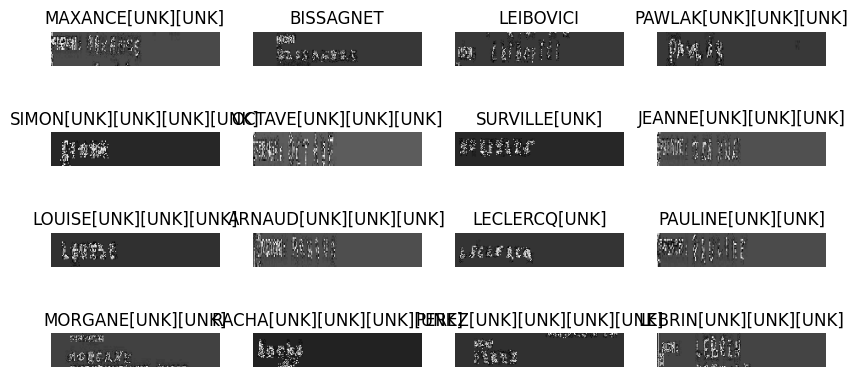

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_148   │ (None, 50, 256)   │    197,632 │ dropout_74[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_149   │ (None, 50, 128)   │    164,352 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 1995.2211 - val_loss: 277.1577
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 1098.7738 - val_loss: 135.9091
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 574.1275 - val_loss: 130.5108
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
(4, 9)
4
4


Model: "functional_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_148               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_149               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


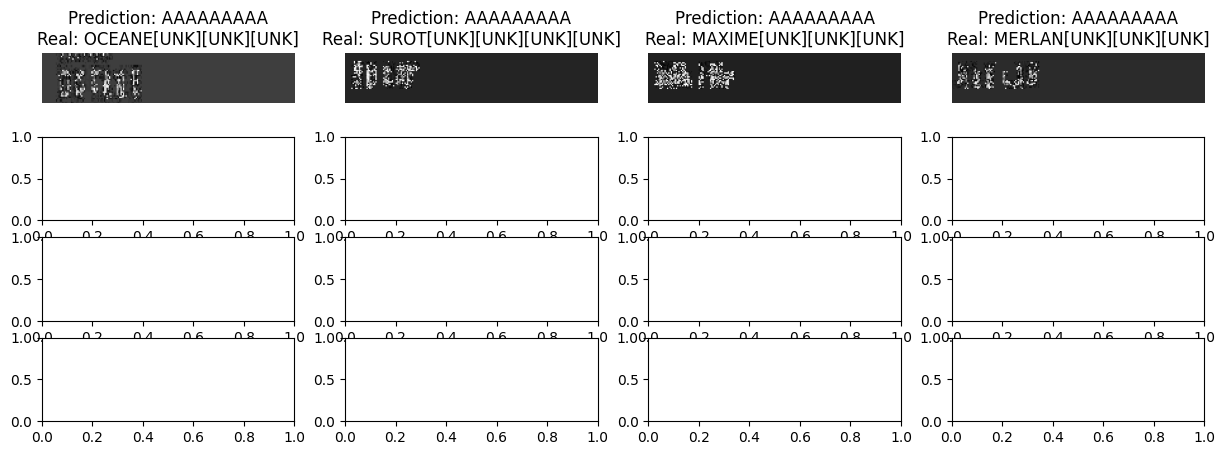

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Average Levenshtein Distance: 21.25
Preprocessing combination: Scaling factor: 0.5, Normalization: minmax


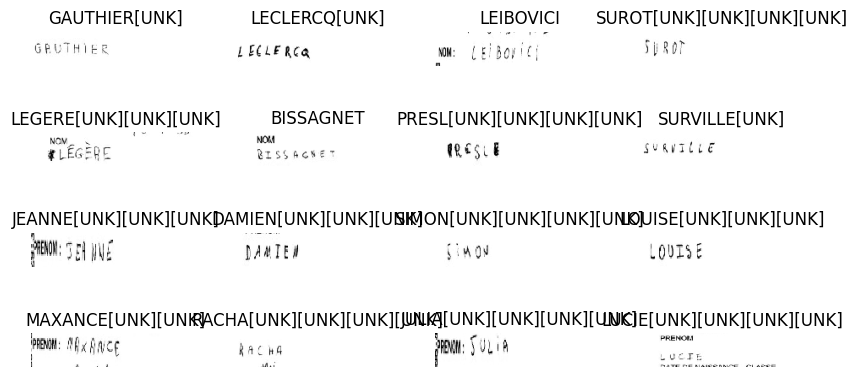

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_150   │ (None, 50, 256)   │    197,632 │ dropout_75[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_151   │ (None, 50, 128)   │    164,352 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1772.8307 - val_loss: 177.6959
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 858.7346 - val_loss: 123.1419
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 521.4986 - val_loss: 131.1542
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
(4, 9)
4
4


Model: "functional_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_150               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_151               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


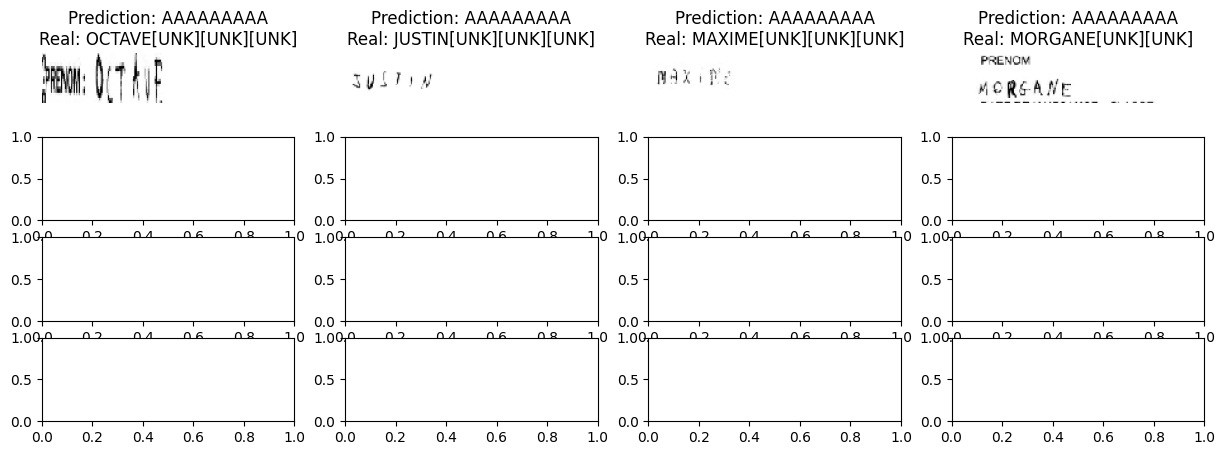

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Average Levenshtein Distance: 19.25
Preprocessing combination: Scaling factor: 1.0, Normalization: zscore


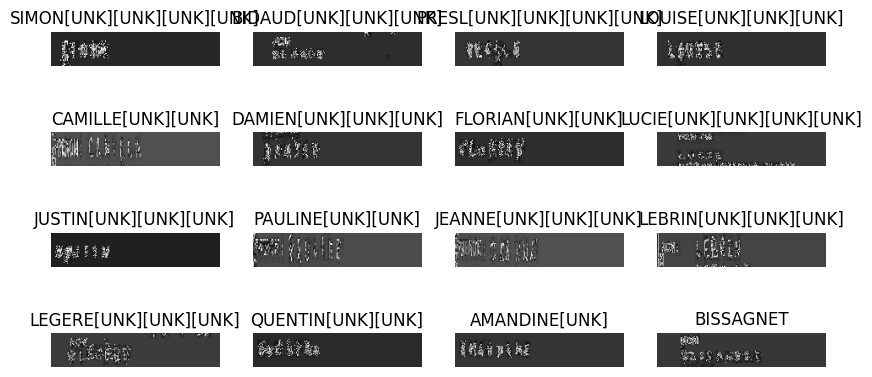

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_152   │ (None, 50, 256)   │    197,632 │ dropout_76[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_153   │ (None, 50, 128)   │    164,352 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 2007.7656 - val_loss: 270.9395
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1136.6345 - val_loss: 138.6688
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 611.3581 - val_loss: 128.9635
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
(4, 9)
4
4


Model: "functional_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_152               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_153               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


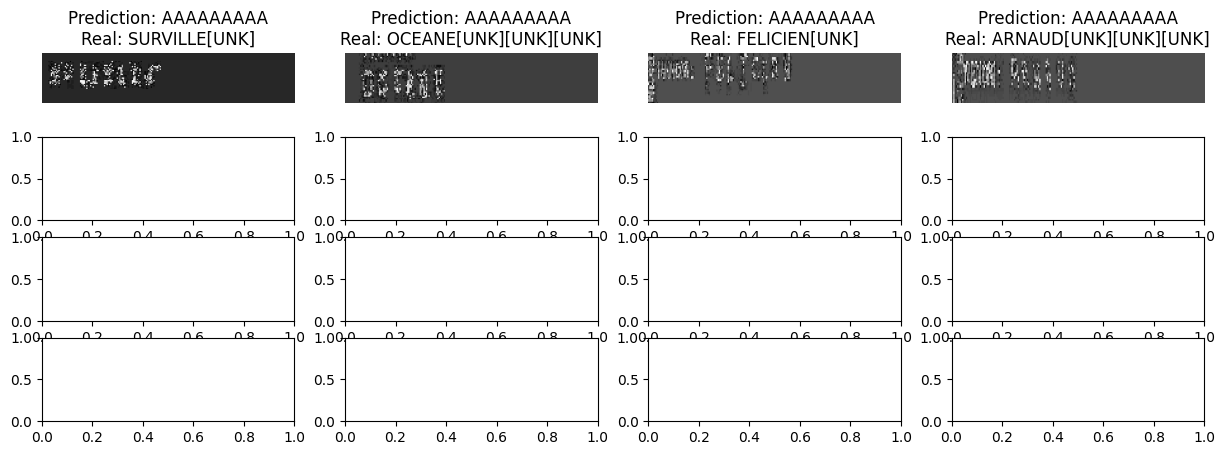

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Average Levenshtein Distance: 16.25
Preprocessing combination: Scaling factor: 1.0, Normalization: minmax


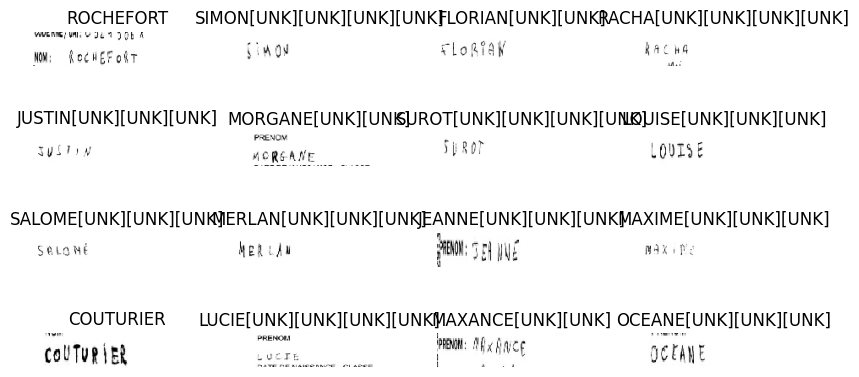

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_154   │ (None, 50, 256)   │    197,632 │ dropout_77[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_155   │ (None, 50, 128)   │    164,352 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 2058.4106 - val_loss: 358.6530
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1294.1632 - val_loss: 320.8528
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 909.8486 - val_loss: 356.4834
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
(4, 9)
4
4


Model: "functional_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_154               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_155               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


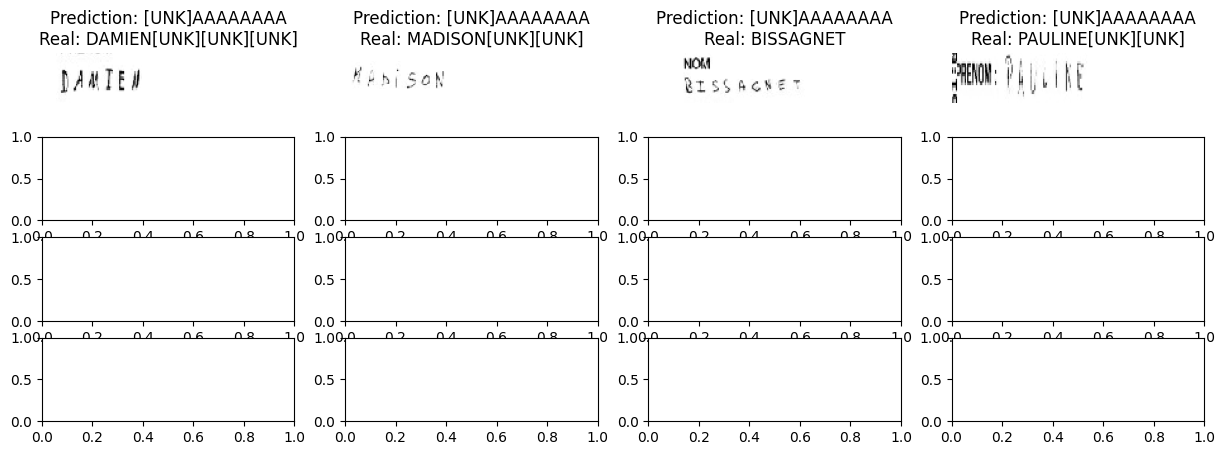

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Average Levenshtein Distance: 14.5
Preprocessing combination: Scaling factor: 1.5, Normalization: zscore


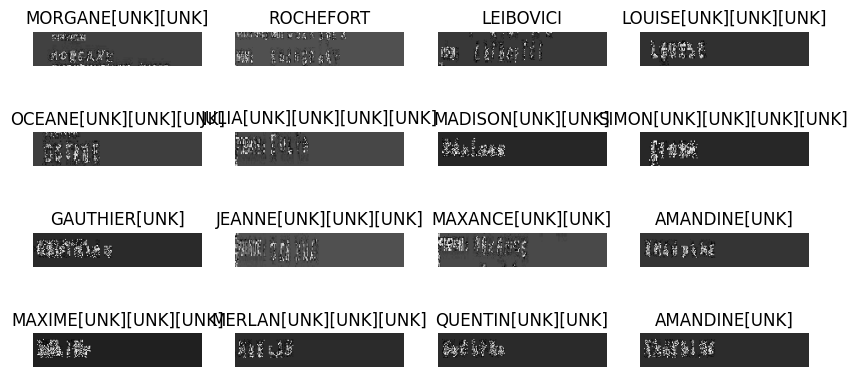

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_156   │ (None, 50, 256)   │    197,632 │ dropout_78[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_157   │ (None, 50, 128)   │    164,352 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 1960.2150 - val_loss: 249.0303
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1050.9108 - val_loss: 126.7631
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 538.5294 - val_loss: 137.7512
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
(4, 9)
4
4


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_156               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_157               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


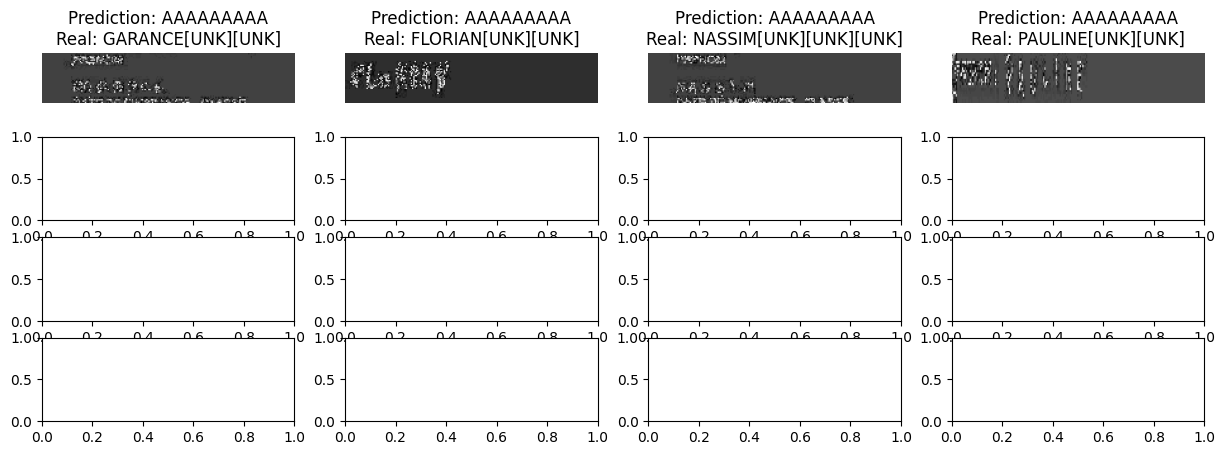

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Levenshtein Distance: 16.75
Preprocessing combination: Scaling factor: 1.5, Normalization: minmax


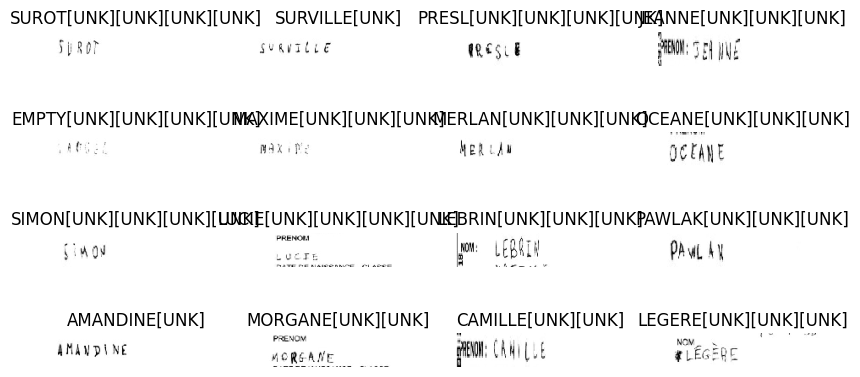

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_158   │ (None, 50, 256)   │    197,632 │ dropout_79[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_159   │ (None, 50, 128)   │    164,352 │ bidirectional_15… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 2007.3304 - val_loss: 374.1866
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - loss: 1452.3480 - val_loss: 238.9876
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 916.9460 - val_loss: 137.0014
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
(4, 9)
4
4


Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_158               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_159               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


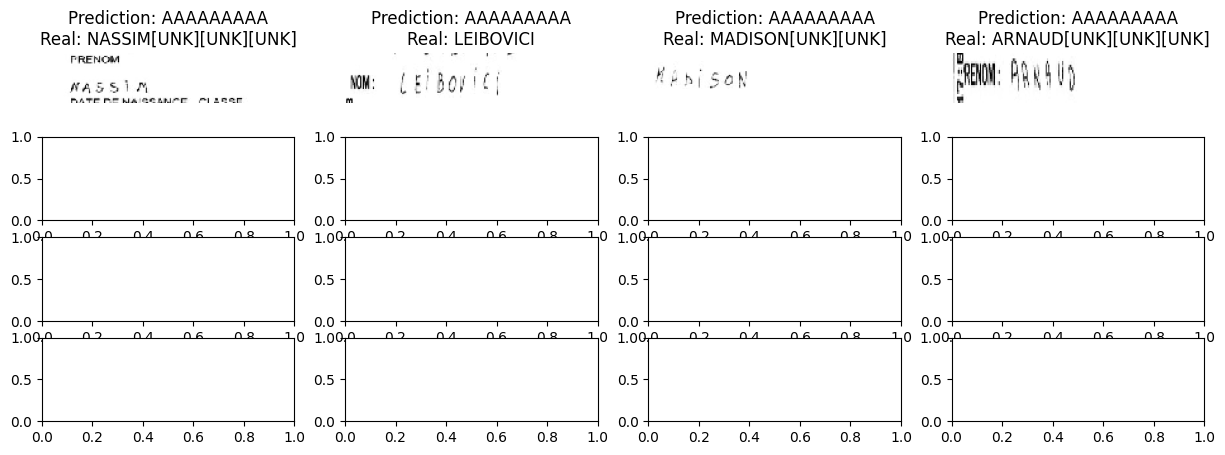

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Levenshtein Distance: 16.0
Results:
Combination: (0.5, 'zscore'), Average Distance: 21.25
Combination: (0.5, 'minmax'), Average Distance: 19.25
Combination: (1.0, 'zscore'), Average Distance: 16.25
Combination: (1.0, 'minmax'), Average Distance: 14.5
Combination: (1.5, 'zscore'), Average Distance: 16.75
Combination: (1.5, 'minmax'), Average Distance: 16.0
Best combination from Experiment 1: (1.0, 'minmax'), Best result: 14.5
Best combination: (1.0, 'minmax'), Best result: 14.5
No significant difference found for combination (0.5, 'zscore').
No significant difference found for combination (0.5, 'minmax').
No significant difference found for combination (1.0, 'zscore').
No significant difference found for combination (1.5, 'zscore').
No significant difference found for combination (1.5, 'minmax').

Experiment 2: Hyperparameter Optimization
Hyperparameter combination: Number of Conv Layers: Filter Size: 5, Activation: tanh


d:\Users\Bartek\Desktop\trajdos\.venv\lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
d:\Users\Bartek\Desktop\trajdos\.venv\lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


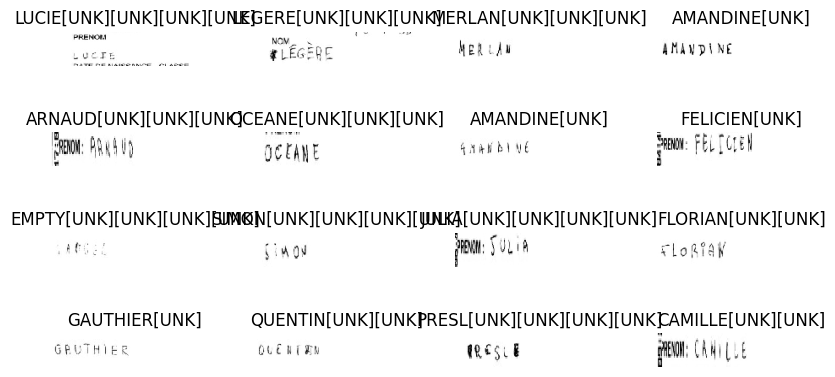

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_160   │ (None, 50, 256)   │    197,632 │ dropout_80[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_161   │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 1983.3097 - val_loss: 237.0016
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - loss: 1012.8151 - val_loss: 123.3692
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 535.2055 - val_loss: 129.7899
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
(4, 9)
4
4


Model: "functional_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_160               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_161               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


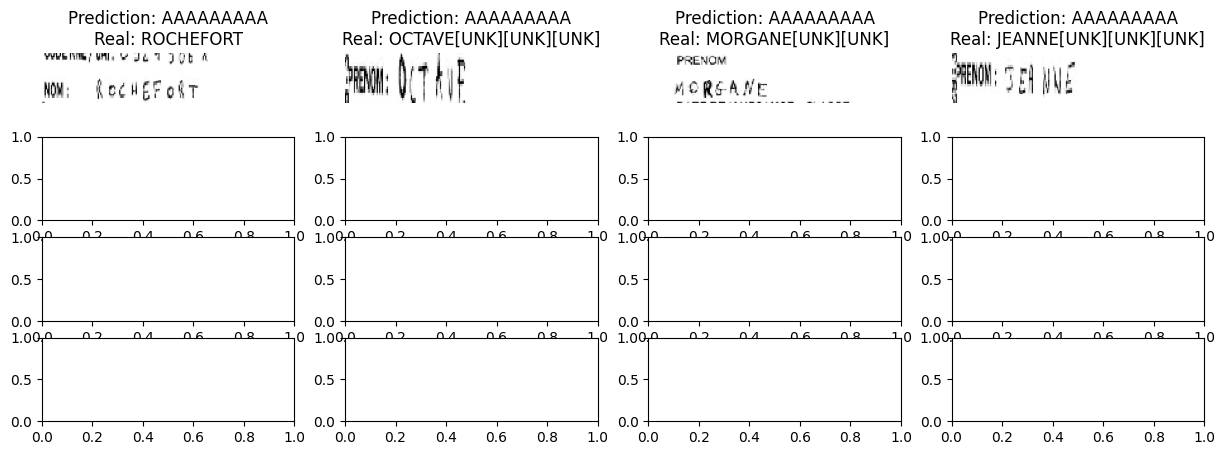

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Levenshtein Distance: 16.25
Hyperparameter combination: Number of Conv Layers: Filter Size: 5, Activation: relu


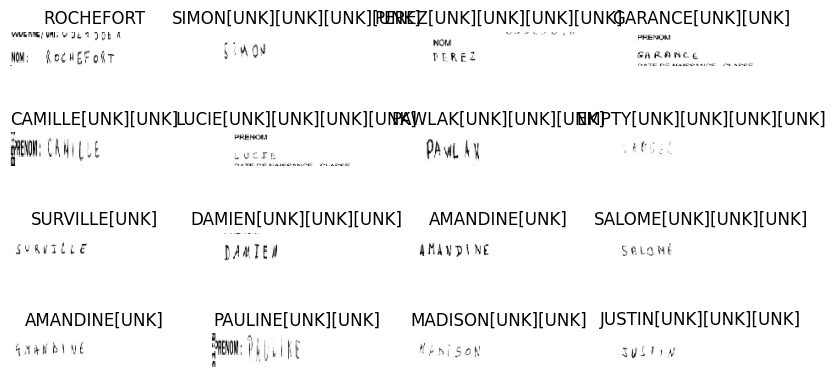

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_162   │ (None, 50, 256)   │    197,632 │ dropout_81[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_163   │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 2021.3645 - val_loss: 253.4946
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1100.8485 - val_loss: 126.0983
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 564.1688 - val_loss: 117.8504
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
(4, 9)
4
4


Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_162               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_163               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


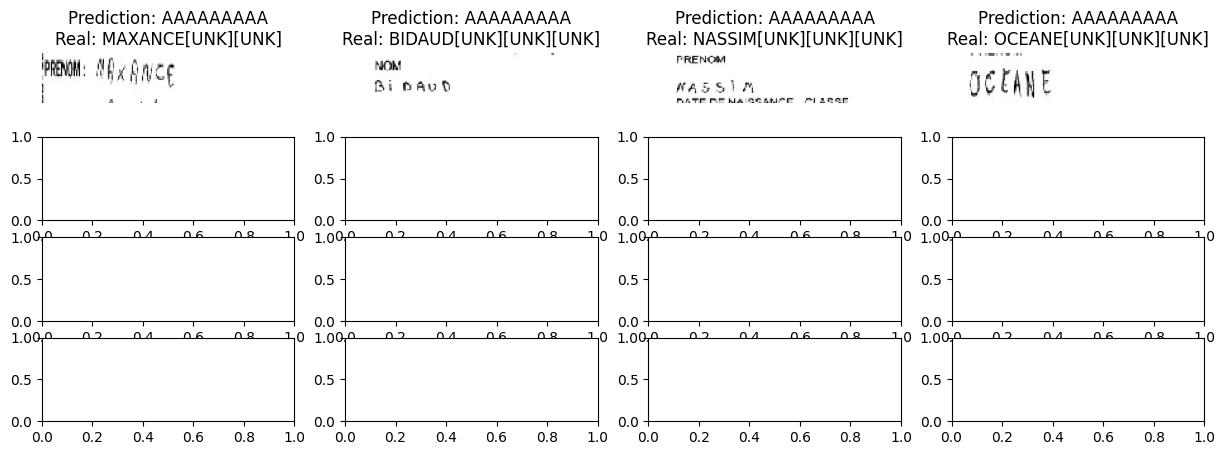

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Average Levenshtein Distance: 18.75
Hyperparameter combination: Number of Conv Layers: Filter Size: 5, Activation: sigmoid


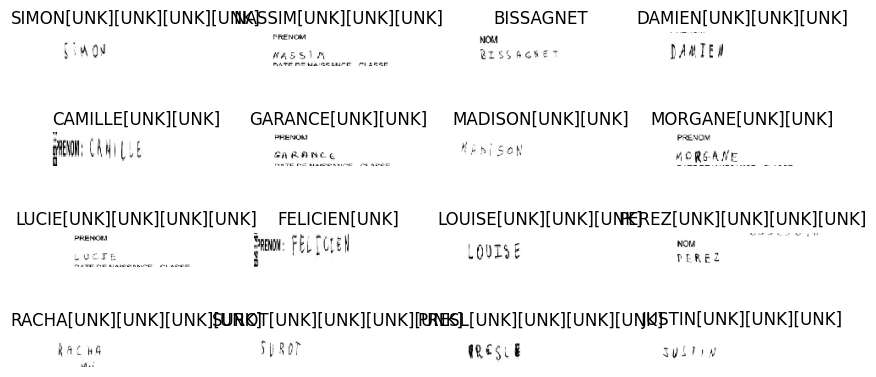

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_164   │ (None, 50, 256)   │    197,632 │ dropout_82[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_165   │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 2016.0602 - val_loss: 317.6883
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 1293.4011 - val_loss: 155.2770
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 700.3860 - val_loss: 117.9765
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
(4, 9)
4
4


Model: "functional_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_164               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_165               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


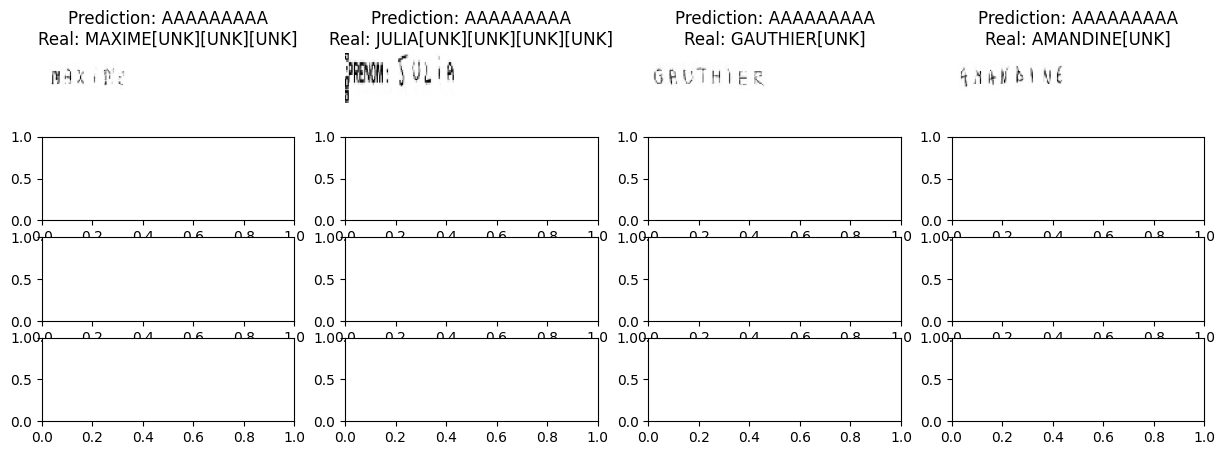

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Average Levenshtein Distance: 16.75
Hyperparameter combination: Number of Conv Layers: Filter Size: 5, Activation: softmax


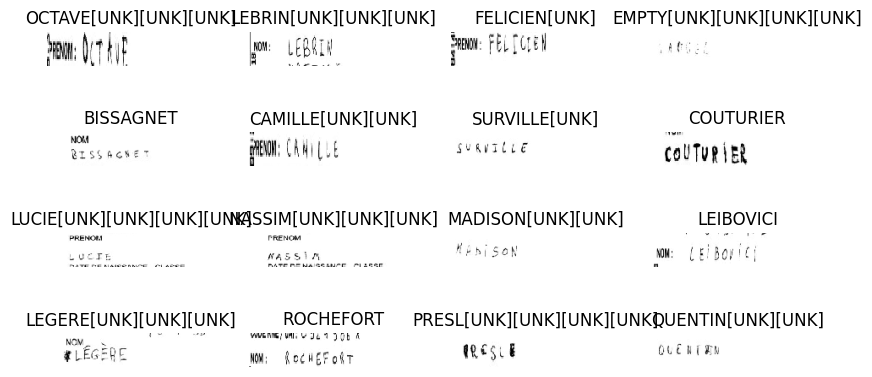

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_166   │ (None, 50, 256)   │    197,632 │ dropout_83[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_167   │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1920.3892 - val_loss: 203.9939
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 929.0977 - val_loss: 120.8589
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 521.7103 - val_loss: 133.8812
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
(4, 9)
4
4


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_166               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_167               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


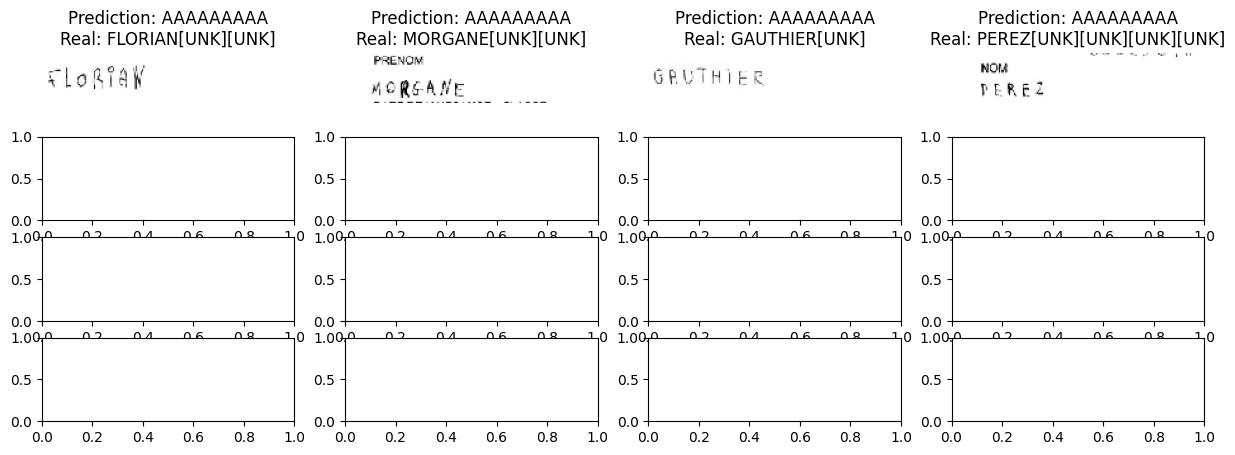

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Average Levenshtein Distance: 17.25
Hyperparameter combination: Number of Conv Layers: Filter Size: 10, Activation: tanh


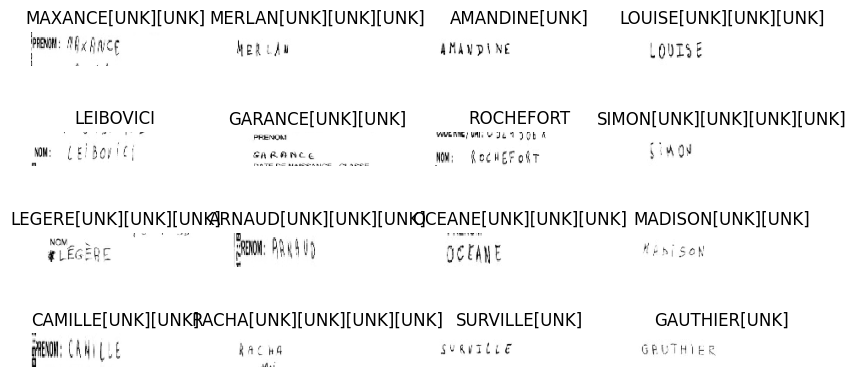

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_168   │ (None, 50, 256)   │    197,632 │ dropout_84[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_169   │ (None, 50, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1798.0859 - val_loss: 181.6917
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 796.1396 - val_loss: 120.0818
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 493.9578 - val_loss: 139.6593
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
(4, 9)
4
4


Model: "functional_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_168               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_169               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


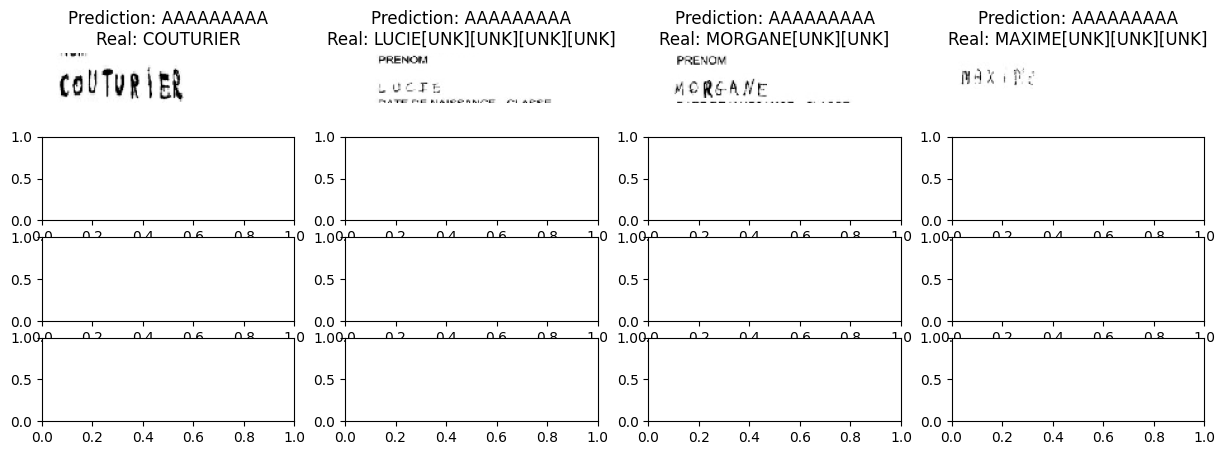

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Average Levenshtein Distance: 17.5
Hyperparameter combination: Number of Conv Layers: Filter Size: 10, Activation: relu


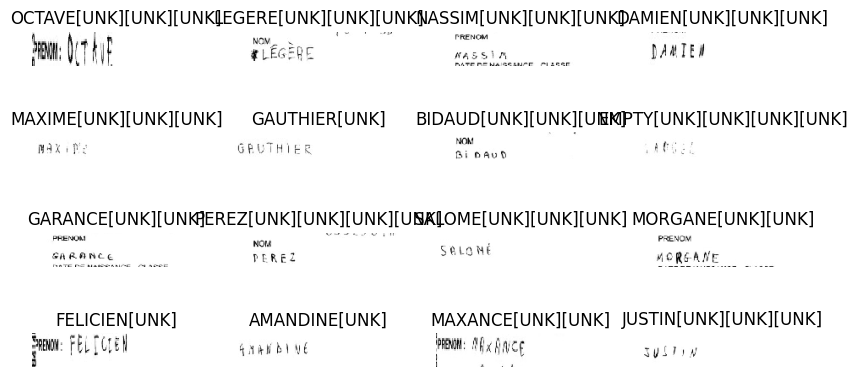

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_170   │ (None, 50, 256)   │    197,632 │ dropout_85[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_171   │ (None, 50, 128)   │    164,352 │ bidirectional_17… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 1950.9374 - val_loss: 237.1087
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1012.9171 - val_loss: 127.6993
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 553.3153 - val_loss: 128.5353
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
(4, 9)
4
4


Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_170               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_171               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


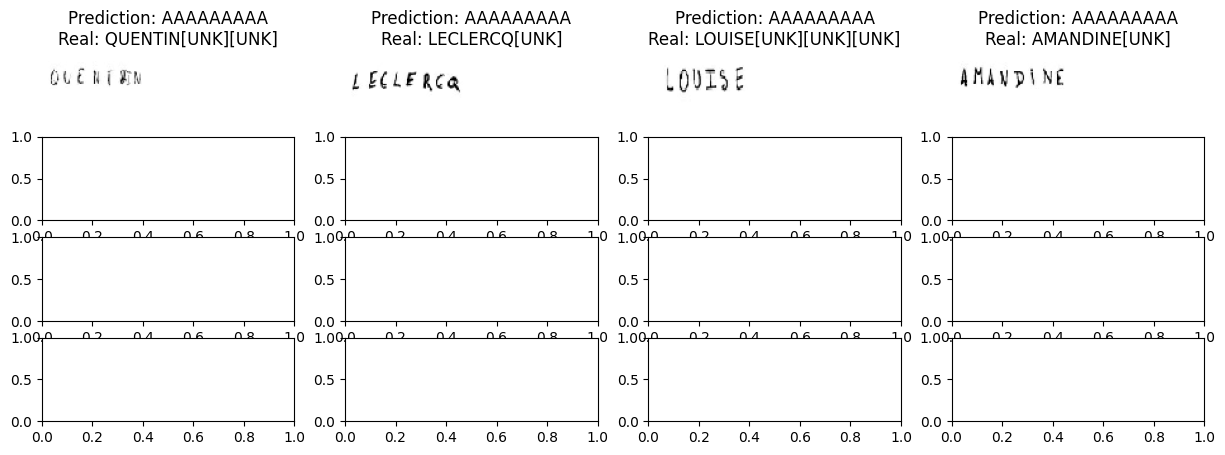

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Average Levenshtein Distance: 15.5
Hyperparameter combination: Number of Conv Layers: Filter Size: 10, Activation: sigmoid


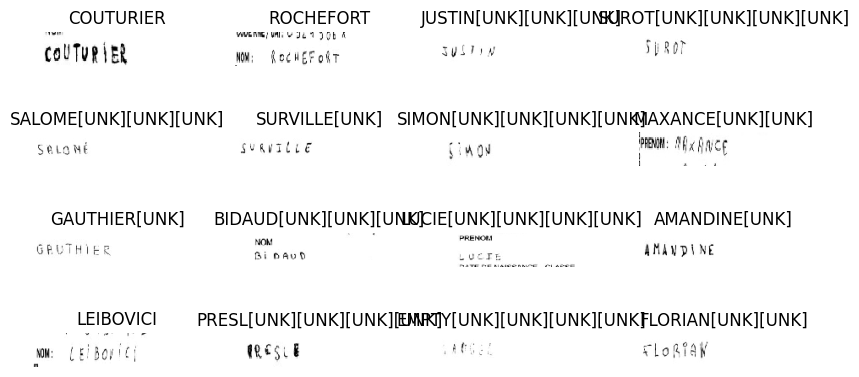

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 40,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 40,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 20,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 20,   │     36,928 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 10,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 640)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     41,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 50, 64)    │          0 │ dense1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_172   │ (None, 50, 256)   │    197,632 │ dropout_86[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_173   │ (None, 50, 128)   │    164,352 │ bidirectional_17… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 28)    │      3,612 │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 28)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 1947.5814 - val_loss: 256.4192
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - loss: 1134.5139 - val_loss: 129.2892
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 581.9214 - val_loss: 123.5896
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
(4, 9)
4
4


Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 20, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 20, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_172               │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_173               │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 28)         │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,188 (1.69 MB)

 Trainable params: 444,188 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

KeyboardInterrupt: 

In [308]:
# Run experiments
print("Experiment 1: Preprocessing Image Techniques")
best_combination1 = experiment_preprocessing()

print("\nExperiment 2: Hyperparameter Optimization")
best_combination2 = experiment_hyperparameters(best_combination1)